# <font color = white > **Stochastic Simulation (5284STSI6Y) | MSc Computational Science at UvA** </font>

# <font color = LightGreen > **Assignment 3: Simulated Annealing** </font>
*By Victor Piaskowski(15132625), Sanjhana Bhusal (14724383), and Lisa Pahladsingh(13846566)*

Link to Github Repository: https://github.com/BiggusVickus/Stochastic_Simulation

In [1]:
# imports
import tsplib95
import random
import matplotlib.pyplot as plt
import math
import copy
import pandas as pd
random.seed(42)

### <font color = Pink > **Main Code: Algorithm Simulated Annealing** </font>

In [2]:
# Class for simulated annealing
class SimulatedAnnealing():
    """this class encompases all of the simulated annealing data, intial/"global" variables, methods, and plotting methods
    """
    def __init__(self, file_name) -> None:
        self.starting_temperature = 5000 # Starting temperature
        self.current_temperature = self.starting_temperature # Current temperature of iteration
        self.stopping_temperature = 0.0001 # Stopping temperature
        self.alpha = 0.99 # Alpha: rate of cooldown
        self.iterations = 1 # Number of iteratoins to do
        self.same_solution_max = 1500 #
        self.same_cost_diff_max = 150000
        self.route_distance = 0 # Distance of route
        self.data = tsplib95.load(file_name) # Data from the file
        self.cities = list(self.data.get_nodes()) # List of cities
        random.shuffle(self.cities) # Randomly shuffle the cities
        self.solution = self.cities # Set current solution to be a random shuffle of the cities
        self.best_route_so_far = self.cities 
        self.type_of_temperature_change = "exponential" # Log, exponential, quadratic, linear - type of rate of change for the temperature
        self.temperature_list = [] # List of temperatures
        self.route_distance_list = [] # List of distances for each step
        self.route_cost_list = [] # List of cost for each step
        self.boltzman_energy_list = [] #List of boltzman energy at each step
        self.minimize_chain_length = False # Either randomly choose how the chain evolves, or choose the one that will minimize the next iteration step
        self.perturbations_options = [0,1,2,3] # Options for perturbing 
        self.max_iter = 5000 # Max iterations in each step
        self.statistical_data = None

        self.total_temperature_list = [] # List of temperature_list, len() = self.iterations
        self.total_route_cost_list = [] # List of total route cost, len() = self.iterations

        self.best_route_iteration_list = [] # Best route list, len() = self.iterations
        self.best_route_cost_iteration_list = [] # Best cost list, len() = self.iterations

    def initialize(self):
        """ Starting point to call, calls function annealing() self.iteration times """
        for i in range(self.iterations):     
            print("Iteration: ", i)
            route, route_cost = self.annealing()
            self.best_route_iteration_list.append(route)
            self.best_route_cost_iteration_list.append(route_cost)

            self.solution = self.cities
            self.best_route_so_far = []
            self.route_distance_list = []
            self.route_cost_list = []
            self.temperature_list = []
            self.current_temperature = self.starting_temperature
            self.route_distance = 0


    def annealing(self):
        """ Main control and logic loop for the simualted annealing algorithm

        Returns:
            list: the best route, a list of length n 
            float: the cost for the best route
        """
        same_solution = 0
        same_cost_diff = 0
        n_iter = 0

        while same_solution < self.same_solution_max and same_cost_diff < self.same_cost_diff_max and n_iter<self.max_iter:
            better_solution = self.potential_better_solution(self.solution)
            
            # Check if neighbor is best so far
            cost_diff = self.get_cost(better_solution) - self.get_cost(self.solution)

            # If the new solution is better, accept it
            if cost_diff > 0:
                self.solution = better_solution
                self.best_route_so_far = better_solution
                same_solution = 0
                same_cost_diff = 0
                
            elif cost_diff == 0:
                self.solution = better_solution
                same_solution = 0
                same_cost_diff += 1
            # If the new solution is not better, accept it with a probability of e^(-cost/temp)
            else:
                if random.uniform(0, 1) <= math.exp(float(cost_diff) / float(self.current_temperature)):
                    self.solution = better_solution
                    same_solution = 0
                    same_cost_diff = 0
                else:
                    same_solution +=1
                    same_cost_diff+=1
            # Decrement the temperature acording to each cooling schedule
            if (self.type_of_temperature_change == "log"):
                self.current_temperature = self.temperatureChangeLog()
            elif (self.type_of_temperature_change == "exponential"):
                self.current_temperature = self.temperatureChangeExponential()
            elif (self.type_of_temperature_change == "quadratic"):
                self.current_temperature = self.temperatureChangeQuadratic(k=n_iter)
            else:
                self.current_temperature = self.temperatureChangeConstant()
                
            self.temperature_list.append(self.current_temperature)
            self.route_cost_list.append(self.get_cost(self.solution))

            n_iter += 1


        self.total_temperature_list.append(self.temperature_list)
        self.total_route_cost_list.append(self.route_cost_list)
        return self.best_route_so_far, self.get_cost(self.best_route_so_far)

    def get_cost(self, state):
        """ Calculates the cost (distance) of a given permutation of cities

        Args:
            state (list): list of cities representing the path to visit

        Returns:
            float: returns the inverse of the sum of euclidean distances between consecutive cities in state
        """
        distance = 0
        for i in range(len(state)):
            from_city = state[i]
            to_city = None
            if i+1 < len(state):
                to_city = state[i+1]
            else:
                to_city = state[0]
            distance += self.data.get_weight(from_city, to_city)
        fitness = 1/float(distance)
        return fitness
        
    def potential_better_solution(self, state):
        """ Depending on if self.minimize_chain_length is true or false, if true, calculate the cost for each possibility of altering (permuting) the route (inverse, insert, swap, swap routes), and choose the one with the minimum cost. If false, randomly choose one of the alterations without considering the one that will immediately minimize the cost. 
        Args:
            state (list): list of cities representing the path to visit

        Returns:
            list: returns list after having been permuted once  
        """
        neighbor = copy.deepcopy(state)
        func = random.choice(self.perturbations_options)
        if (self.minimize_chain_length == True):
            neighbor1 = self.inverse(neighbor)
            neighbor2 = self.insert(neighbor)
            neighbor3 = self.swap(neighbor)
            neighbor4 = self.swap_routes(neighbor)
            cost1 = self.get_cost(neighbor1)
            cost2 = self.get_cost(neighbor2)
            cost3 = self.get_cost(neighbor3)
            cost4 = self.get_cost(neighbor4)
            cost_list = [cost1, cost2, cost3, cost4]
            minimum = min(cost_list)
            func = cost_list.index(minimum)
            if (func == 0):
                neighbor = neighbor1
            elif (func == 1):
                neighbor = neighbor2
            elif (func == 2):
                neighbor = neighbor3
            else:
                neighbor = neighbor4
        else:
            if func == 0:
                neighbor = self.inverse(neighbor)
            elif func == 1:
                neighbor = self.insert(neighbor)
            elif func == 2 :
                neighbor = self.swap(neighbor)
            else:
                neighbor = self.swap_routes(neighbor)
        return neighbor 

    def inverse(self, state):
        """ Choose 2 cities, and inverse the order of the routes between the 2 cities

        Args:
            state (list): list of cities representing the path to visit

        Returns:
            list: list of cities after a subsection of the route has been inversed
        """
        node_one = random.choice(state)
        new_list = list(filter(lambda city: city != node_one, state)) #route without the selected node one
        node_two = random.choice(new_list)
        state[min(node_one,node_two):max(node_one,node_two)] = state[min(node_one,node_two):max(node_one,node_two)][::-1]
        return state

    def insert(self, state):
        """ Perform an insert operation on a given state. The function randomly selects two cities from the state, removes the first selected city, and inserts it at the position of the second selected city.

        Args:
            state (list): list of cities representing the path to visit

        Returns:
            list: list of cities after a city has been moved to a new position in the route
        """
        node_j = random.choice(state)
        state.remove(node_j)
        node_i = random.choice(state)
        index = state.index(node_i)
        state.insert(index, node_j)
        return state

    def swap(self, state):
        """ Randomly choose 2 cities and swap them with one another

        Args:
            state (list): list of cities representing the path to visit

        Returns:
            list: new route after having 2 cities
        """
        pos_one = random.choice(range(len(state)))
        pos_two = random.choice(range(len(state)))
        state[pos_one], state[pos_two] = state[pos_two], state[pos_one]
        return state

    def swap_routes(self, state):
        """ Perform a swap operation on a given state. The function randomly selects two subroutes from the state, removes the first selected subroute, and inserts it at a random position.

        Args:
            state (list): list of cities representing the path to visit

        Returns:
            list: list of cities after performing a swap operation
        """
        subroute_a = random.choice(range(len(state)))
        subroute_b = random.choice(range(len(state)))
        subroute = state[min(subroute_a,subroute_b):max(subroute_a, subroute_b)]
        del state[min(subroute_a,subroute_b):max(subroute_a, subroute_b)]
        insert_pos = random.choice(range(len(state)))
        for i in subroute:
            state.insert(insert_pos, i)
        return state
    
    def plot_route(self):
        """ Plots the routes that salesman should take on an x-y plane
        """
        # Plot Routes
        for i in range(0, len(self.best_route_iteration_list)):
            xs = [self.data.node_coords[i][0] for i in self.best_route_iteration_list[i]]
            ys = [self.data.node_coords[i][1] for i in self.best_route_iteration_list[i]]
            # 'bo-' means blue color, round points, solid lines
            plt.figure()
            plt.plot(xs, ys, label="Distance: " + str(1/self.best_route_cost_iteration_list[i]))
            plt.xlabel('X Coordinates')
            plt.ylabel('Y Coordinates')
            plt.title('Simulated Annealing')
            plt.legend()

    def plot_route_distance_list(self):
        """ Plots the cost of the route at each temperature measurement taken
        """
        for i in range(0, len(self.total_route_cost_list)):
            fig, ax1 = plt.subplots()

            ax1.set_xlabel('Temperature')
            ax1.set_ylabel('Cost')
            ax1.plot(self.total_temperature_list[i], self.total_route_cost_list[i], 'r', label="Cost", linewidth=0.5)
            ax1.tick_params(axis='y')
    
    def iteration_distance(self):
        """ Plots the distance vs iteration count with temperature as a secondary y axis
        """

        fig, ax1 = plt.subplots()
        color = 'black'
        ax1.set_xlabel('Iterations (n)', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Distance (km)', color=color, fontsize=12, fontweight='bold')

        # Plotting distance vs iteration count
        for i in range(len(self.total_route_cost_list)):
            distances = [1 / cost for cost in self.total_route_cost_list[i]]
            iterations = range(len(distances))
            ax1.plot(iterations, distances, 'r', linewidth=0.5)

        # Plotting temperature vs iteration count
        ax2 = ax1.twinx()
        ax2.set_ylabel('Temperature', color="green", fontsize=12, fontweight='bold')
        for i in range(len(self.total_temperature_list)):
            temperature_trajectory = self.total_temperature_list[i]
            iterations = range(len(temperature_trajectory))
            ax2.plot(iterations, temperature_trajectory, linewidth=0.5)

        ax1.tick_params(axis='y', labelcolor=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Adding legend for only first run
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right', prop={"size": 14})

        # plt.legend() # optional
        plt.show()

    def temperature_trajectory(self):
        fig, ax1 = plt.subplots(dpi=300)
        color = 'black'
        ax1.set_xlabel('Iterations (n)', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Temperature (C)', color=color, fontsize=12, fontweight='bold')

        for i in range(len(self.total_temperature_list)):
            temperature_trajectory = self.total_temperature_list[i]
            iterations = range(len(temperature_trajectory))
            ax1.plot(iterations, temperature_trajectory, color='red',linewidth=2.0, label='Linear') # Adjust label for each cooling schedule
        plt.legend(prop={"size": 14})
        plt.show()

    def iteration_confidence(self, title=False, xlabel="Iteration (n)", ylabel="Distance (km)"):
        """plots confidence interval of the distance at each iteration

        Args:
            title (bool, optional): title of the plot. Defaults to False.
            xlabel (str, optional): x label name. Defaults to "Iteration".
            ylabel (str, optional): y label name. Defaults to "Distance".
        """
        plot_df = pd.DataFrame(self.total_route_cost_list).T
        plot_df = (1/plot_df)

        plot_df['var'] = plot_df.std(axis=1, skipna=True)
        plot_df['mean'] = plot_df.mean(axis=1, skipna=True)

        plt.figure(figsize=(10, 6), dpi=300)

        plt.plot(plot_df.index, plot_df['mean'], color='orange', linewidth=2)
        plt.fill_between(plot_df.index, plot_df['mean'] - 2 * plot_df['var'], plot_df['mean'] + 2 * plot_df['var'],
                         color='gold', alpha=0.4)
        
        # NOTE FOR LISA: elke cooling schedule andere kleur gebruiken:
        # darkblue met CI #52bced voor log
        # red met CI maroon    voor linear
        # green met CI olive   voor quadratic
        # orange met CI gold   voor constant

        if title:
            plt.title('Convergence of distance with varying cooling schedules' , fontsize=20, fontweight='bold')

        if xlabel:
            plt.xlabel(xlabel, fontsize=16, fontweight='bold')

        if ylabel:
            plt.ylabel(ylabel, fontsize=16, fontweight='bold')

        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # Save for later usage
        self.statistical_data = plot_df

        return
    
    def temperatureChangeLog(self, k=0):
        """ Reduce temperature by a logarithmic equation new_temp = start_temp/ (1+alpha * log(k+1))

        Args:
            k (int, optional): iteration step. Defaults to 0.

        Returns:
            float: new temperature after being reduced by a logarithmic value
        """
        # Return self.alpha/(1/(math.log(1+self.current_temperature)))
        return self.starting_temperature / (1 + self.alpha * math.log(k + 1))
    
    def temperatureChangeExponential(self):
        """ Reduce temperature by an exponential amount new_temp = alpha*current_temp

        Returns:
            float: new temperature after being reduced by an exponential value
        """
        return (self.alpha)*self.current_temperature
    
    def temperatureChangeQuadratic(self, k=0):
        """ Reduce temperature by a quadratic equation new_temp = start_temp/ (1+alpha * k^2)

        Args:
            k (int, optional): iteration step. Defaults to 0.

        Returns:
            float: new temperature after being reduced by a constant value
        """
        # return self.current_temperature*math.pow(self.current_temperature, self.alpha)
        return self.starting_temperature / (1 + self.alpha * k**2)
    
    def temperatureChangeConstant(self):
        """ Reduce temperature by a constant value new_temp = old_temp-alpha

        Returns:
            float: new temperature after being reduced by a constant value
        """
        return self.current_temperature - self.alpha
            


### <font color = Pink > **Generating different plots** </font>
#### <font color = White > **Effect of cooling schedules** </font>

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


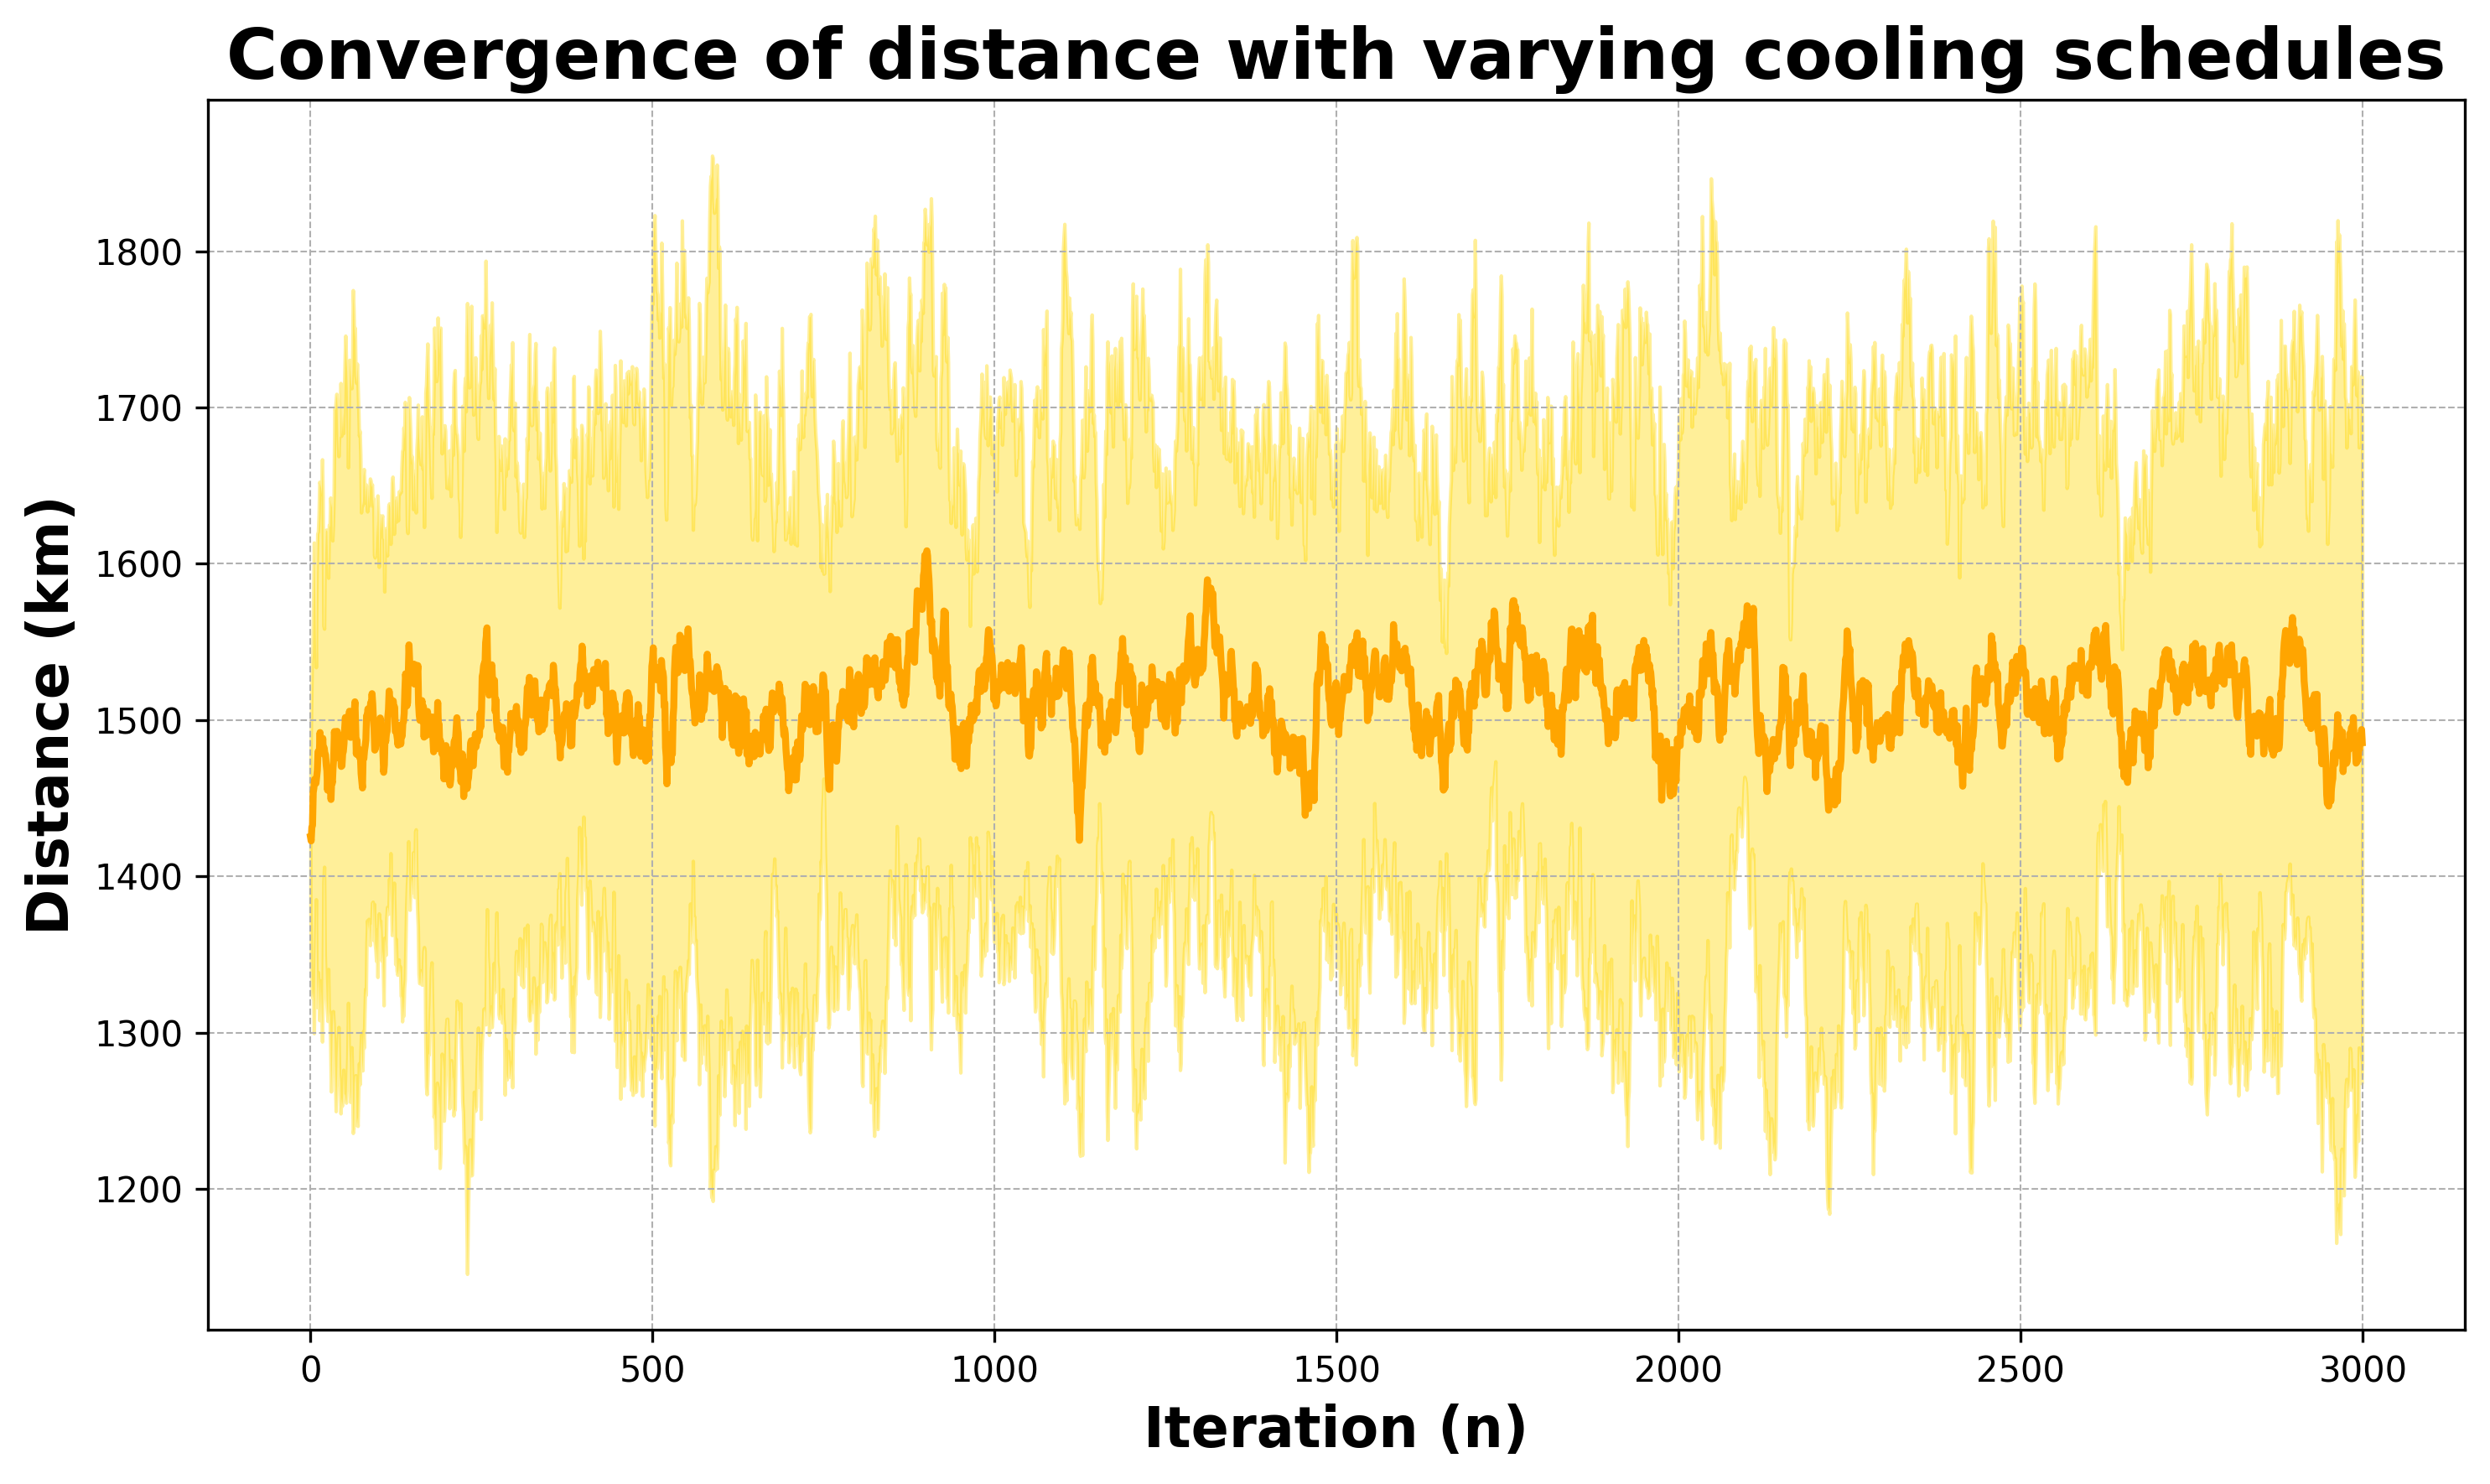

In [9]:
initial = SimulatedAnnealing('eil51.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.minimize_chain_length = False
initial.type_of_temperature_change = "quadratic" # Log, linear, quadratic, exponential
initial.max_iter = 3000
initial.iterations = 10

# Run with current settings
initial.initialize()
initial.iteration_confidence(title="test title")

#### <font color = White > **Temperature trajectories** </font>

Iteration:  0


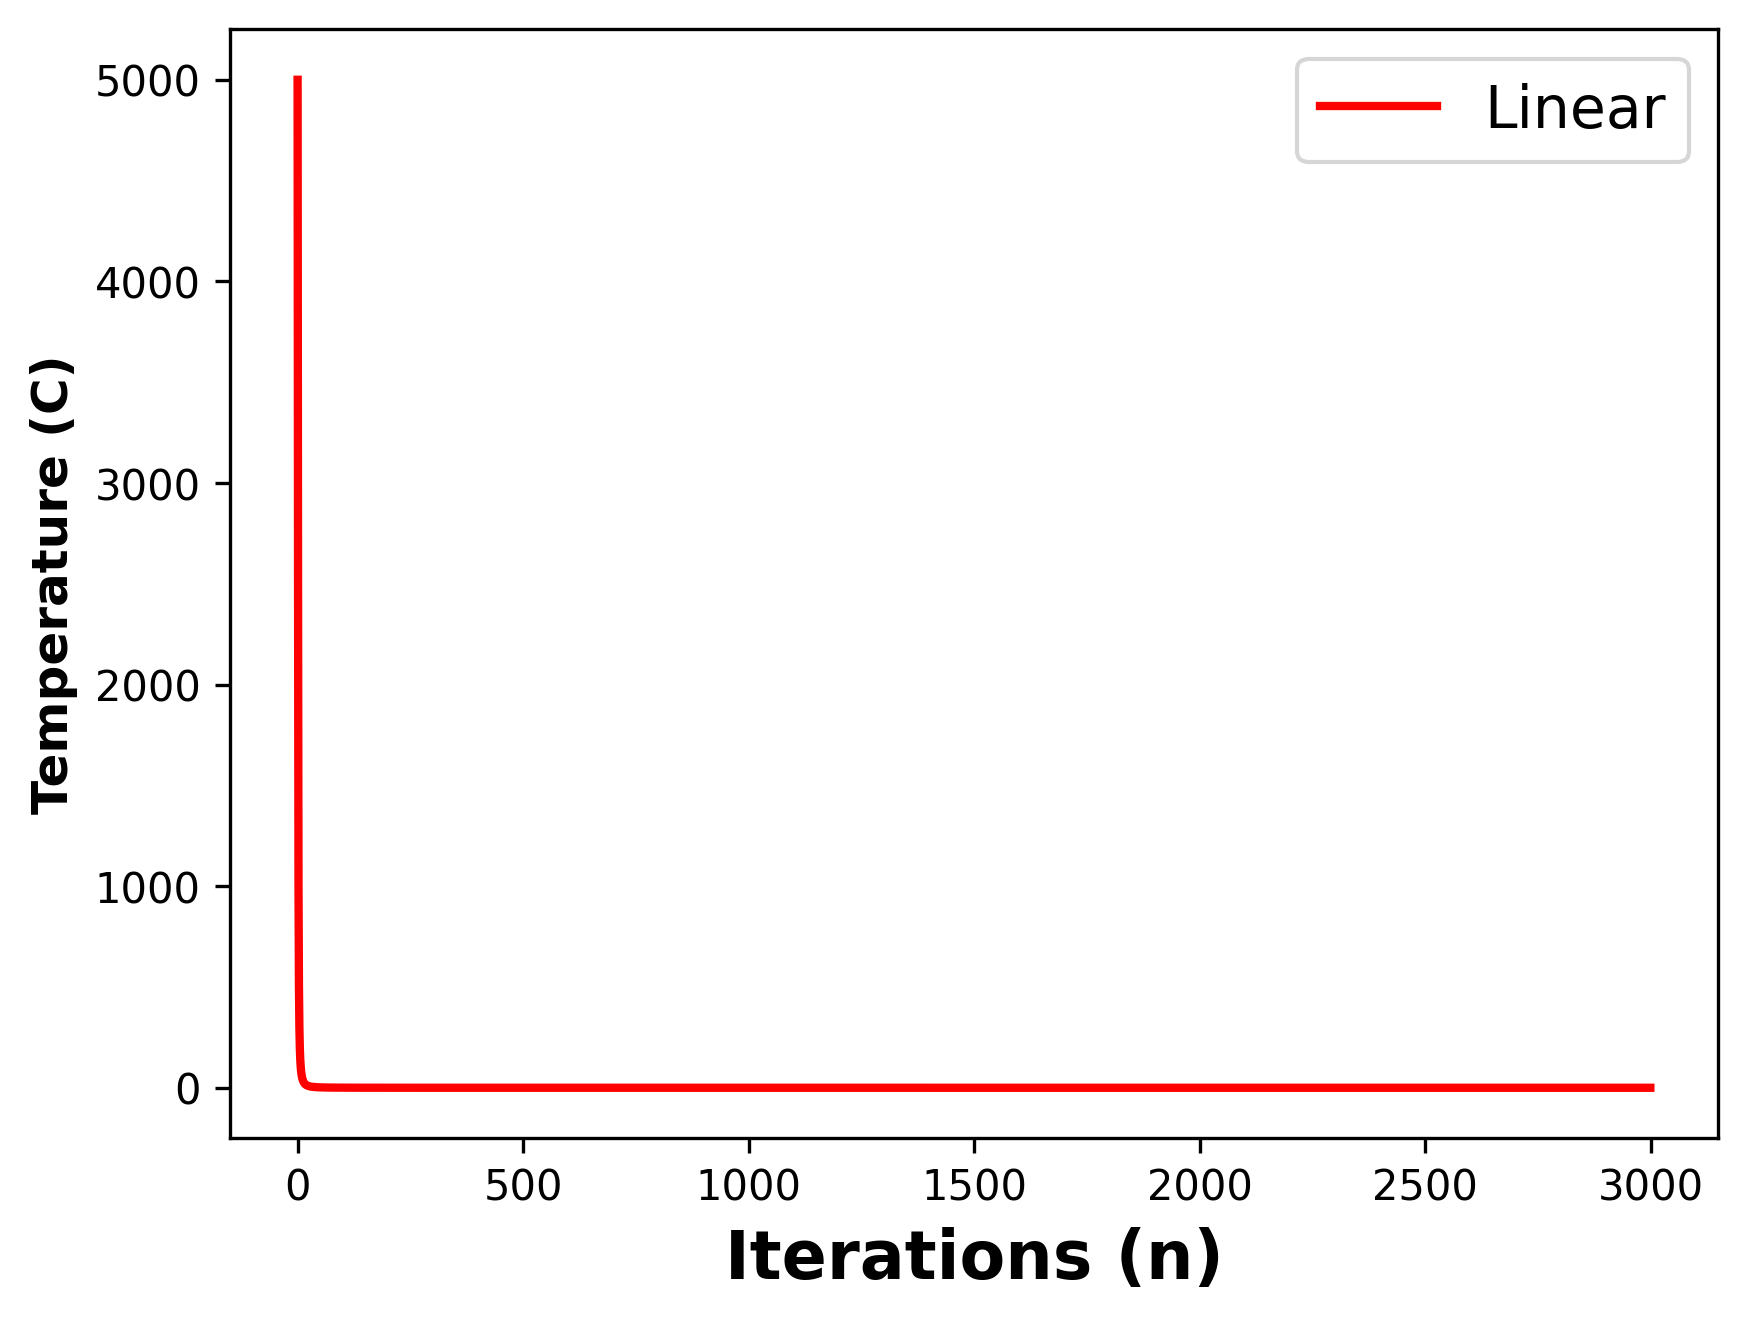

In [10]:
initial = SimulatedAnnealing('eil51.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.minimize_chain_length = False
initial.type_of_temperature_change = "quadratic" # Log, linear, quadratic, constant
initial.max_iter = 3000
initial.iterations = 1

# run with current settings
initial.initialize()
initial.temperature_trajectory() 


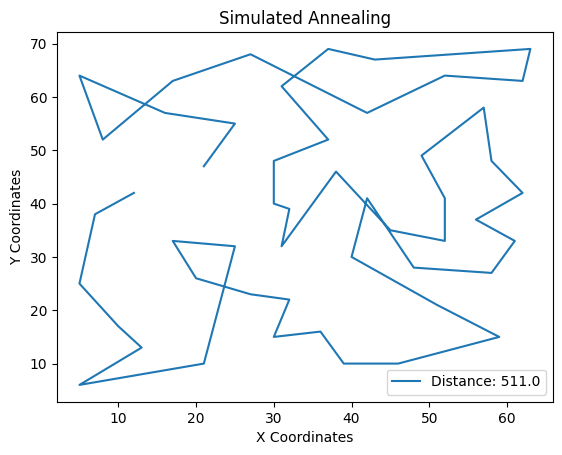

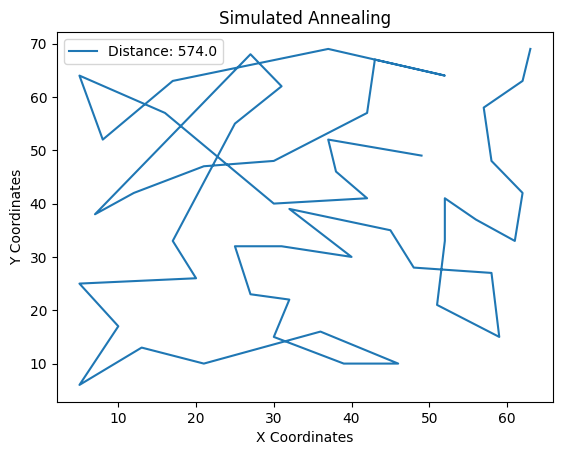

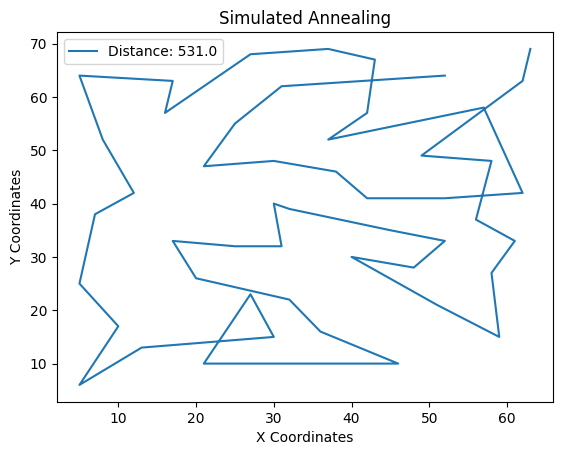

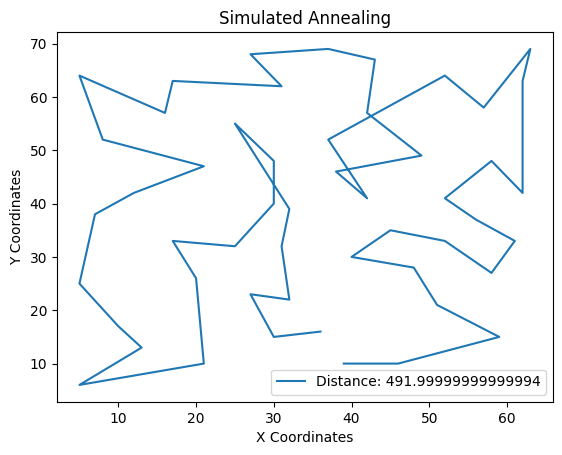

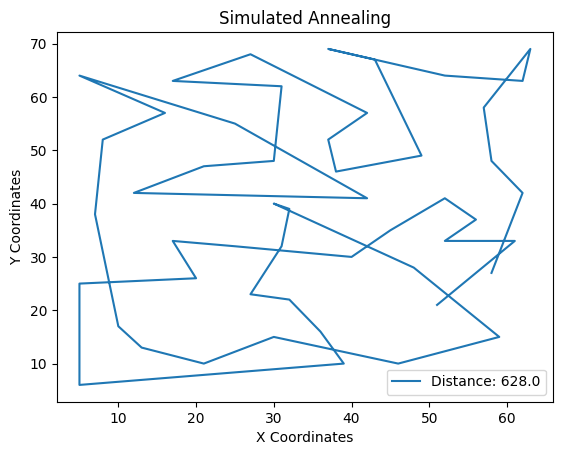

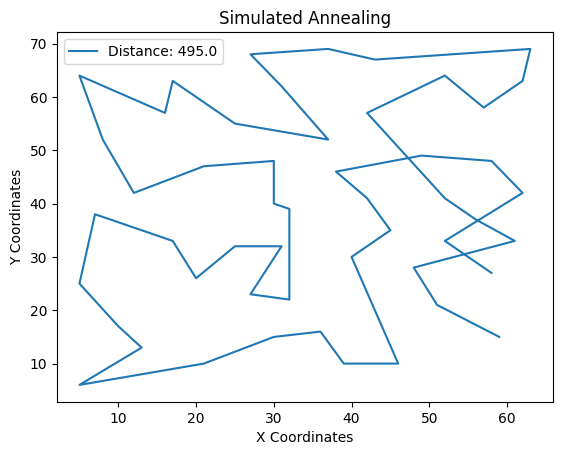

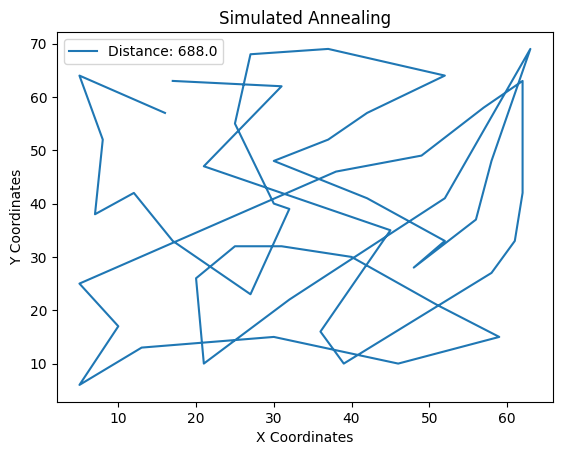

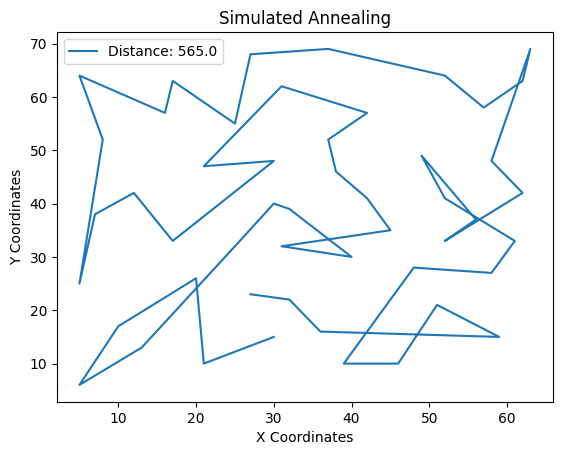

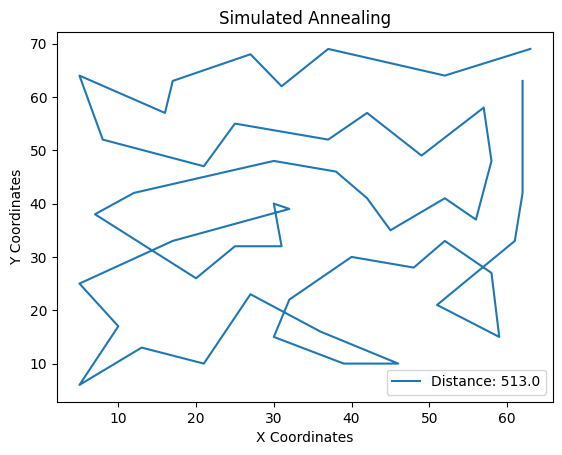

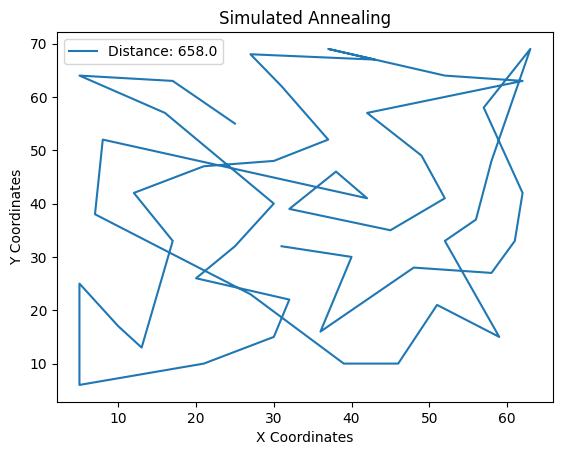

In [13]:

initial.plot_route()

## Q1.1 implementation eil51

Iteration:  0


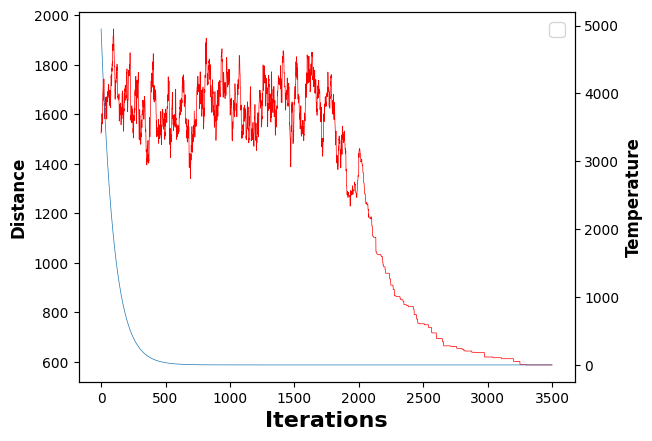

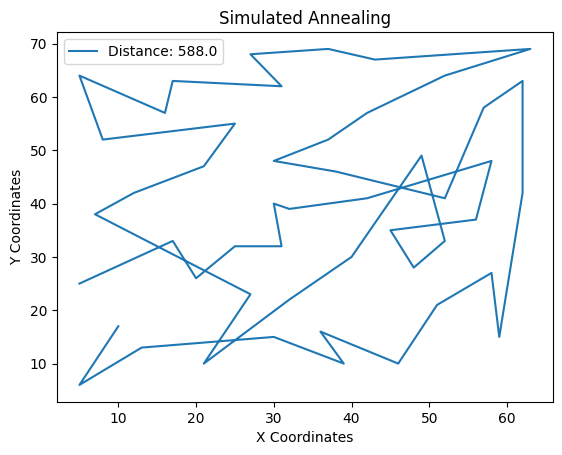

In [7]:
initial = SimulatedAnnealing('eil51.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.iterations = 1
initial.max_iter = 3500

# run with current settings
initial.initialize()
initial.iteration_distance()
initial.plot_route()

## Q1.2 implementation a280

Iteration:  0


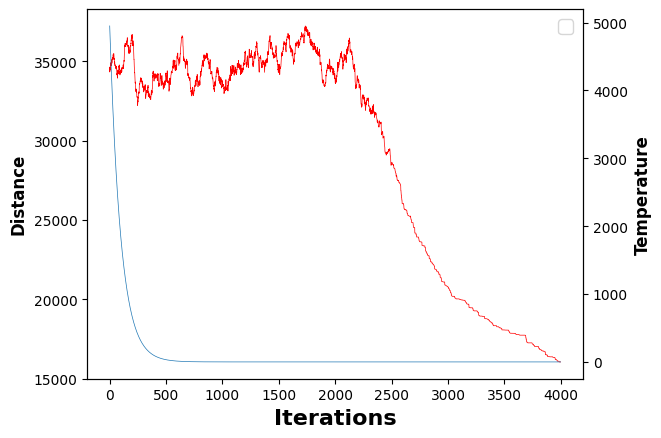

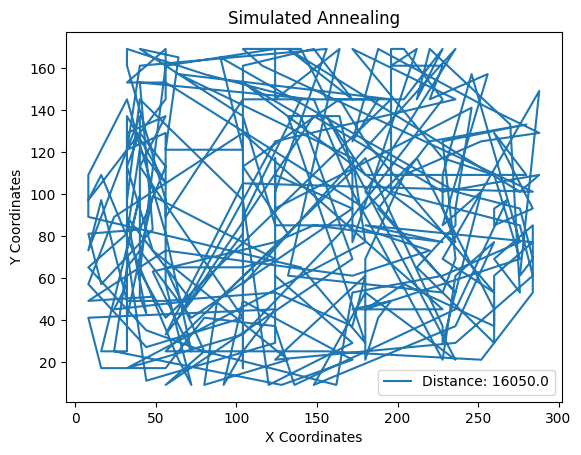

In [8]:
initial = SimulatedAnnealing('a280.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.iterations = 1
initial.max_iter = 4000

# run with current settings
initial.initialize()
initial.iteration_distance()
initial.plot_route()

## Q1.2 implementation pcb442

Iteration:  0


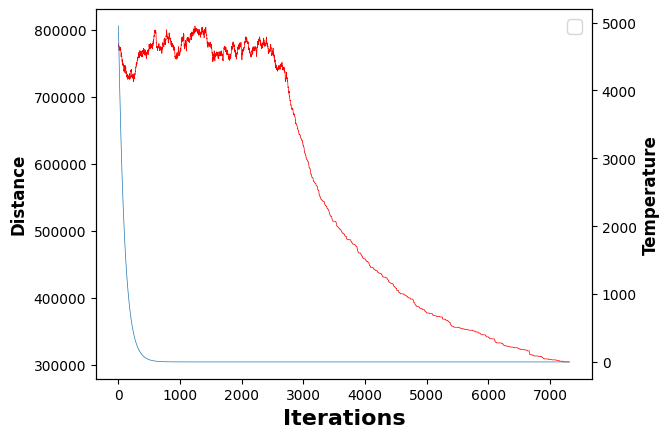

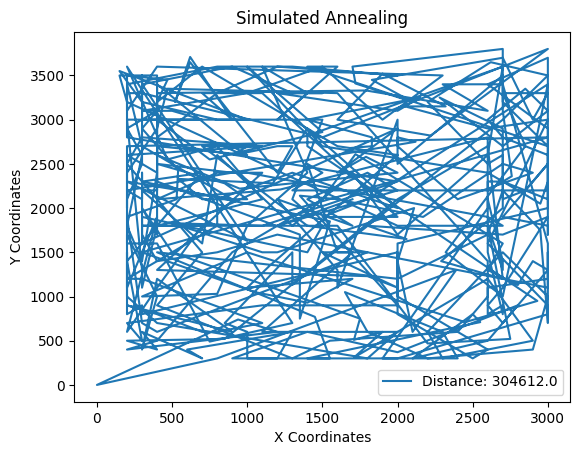

In [9]:
initial = SimulatedAnnealing('pcb442.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.iterations = 1
initial.max_iter = 7500

# run with current settings
initial.initialize()
initial.iteration_distance()
initial.plot_route()

## Q2 implementation cooling method
Here you can change the type of cooling method to see which converges the best

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


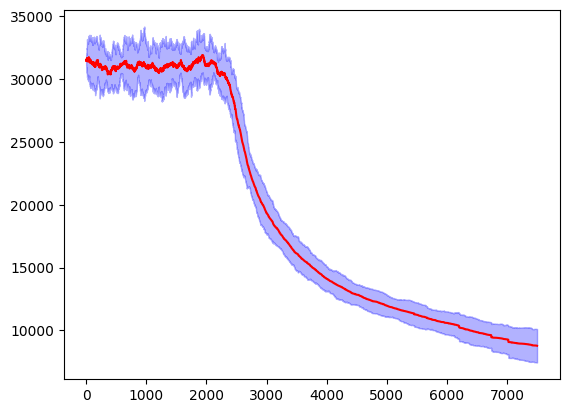

In [10]:
 # NOTE FOR LISA: elke cooling schedule andere kleur gebruiken:
        # darkblue met CI #52bced voor log
        # red met CI maroon    voor linear
        # green met CI olive   voor quadratic
        # orange met CI gold   voor constant

# Linear
initial_linear = SimulatedAnnealing('a280.tsp')
initial_linear.same_solution_max = 100
initial_linear.same_cost_diff_max = 500
initial_linear.type_of_temperature_change = "linear" # change this: log, exponential, quadratic, linear
initial_linear.iterations = 10
initial_linear.max_iter = 7500

# run with current settings
initial_linear.initialize()
initial_linear.iteration_confidence(title='Linear', color_line='orange', color_fill='gold')
initial_linear.temperature_trajectory(title='Linear') 

# Log
initial_log = SimulatedAnnealing('a280.tsp')
initial_log.same_solution_max = 100
initial_log.same_cost_diff_max = 500
initial_log.type_of_temperature_change = "log" # change this: log, exponential, quadratic, linear
initial_log.iterations = 10
initial_log.max_iter = 7500

# run with current settings
initial_log.initialize()
initial_log.iteration_confidence(title='Logarithmic', color_line='darkblue', color_fill='#52bced')
initial_log.temperature_trajectory(title='Logarithmic') 

# Exponential
initial_exp = SimulatedAnnealing('a280.tsp')
initial_exp.same_solution_max = 100
initial_exp.same_cost_diff_max = 500
initial_exp.type_of_temperature_change = "exponential" # change this: log, exponential, quadratic, linear
initial_exp.iterations = 10
initial_exp.max_iter = 7500

# run with current settings
initial_exp.initialize()
initial_exp.iteration_confidence(title='Exponential', color_line='green', color_fill='olive')
initial_exp.temperature_trajectory(title='Exponential') 

initial_quad = SimulatedAnnealing('a280.tsp')
initial_quad.same_solution_max = 100
initial_quad.same_cost_diff_max = 500
initial_quad.type_of_temperature_change = "quadratic" # change this: log, exponential, quadratic, linear
initial_quad.iterations = 10
initial_quad.max_iter = 7500

# run with current settings
initial_quad.initialize()
initial_quad.iteration_confidence(title='Quadratic', color_line='red', color_fill='maroon')
initial_quad.temperature_trajectory(title='Quadratic') 

## Q3 Markov chain length
Optimising perturbations per iteration should lead to a quicker convergence thus lower markov chain

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


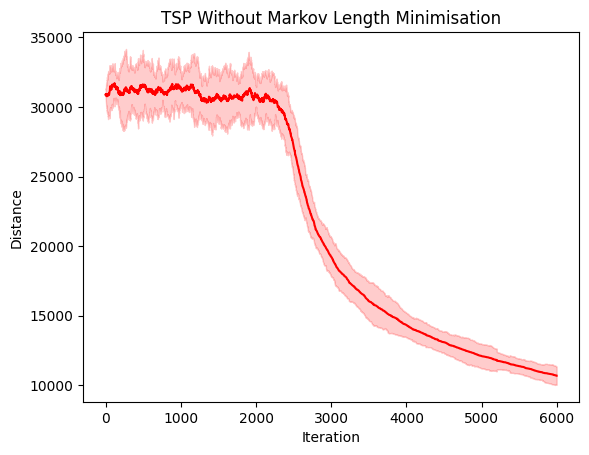

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


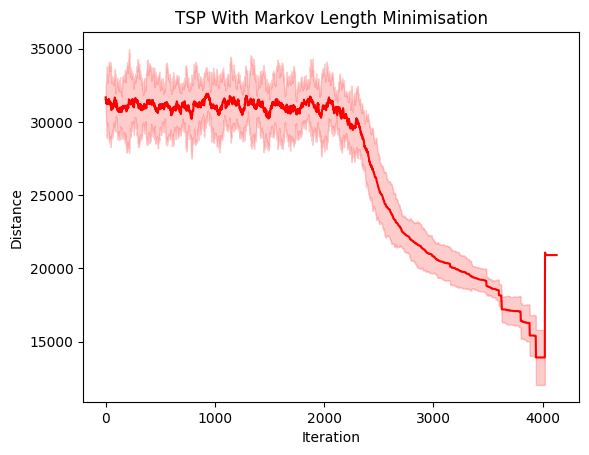

In [25]:
initial = SimulatedAnnealing('a280.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.minimize_chain_length = False
initial.type_of_temperature_change = "linear"
initial.iterations = 10
initial.max_iter = 6000

# run with current settings
initial.initialize()
# initial.iteration_distance()
initial.iteration_confidence(title='TSP Without Markov Length Minimisation')

# minimise chain length
initial = SimulatedAnnealing('a280.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.minimize_chain_length = True
initial.type_of_temperature_change = "linear"
initial.iterations = 10
initial.max_iter = 6000

# run with current settings
initial.initialize()
# initial.iteration_distance()
initial.iteration_confidence(title='TSP With Markov Length Minimisation')

## Extra 1: compare different values of alpha for log cooling

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


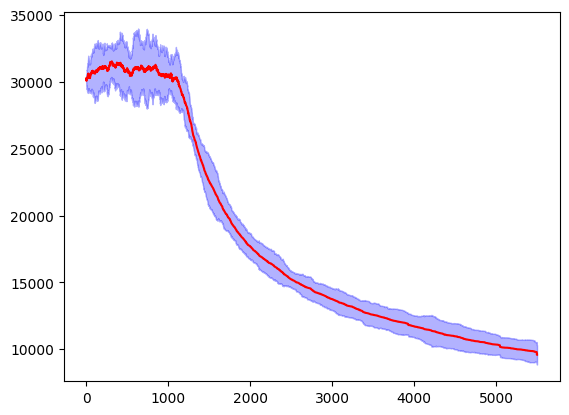

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


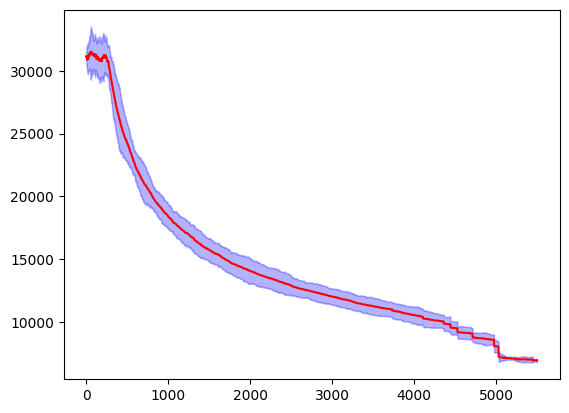

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


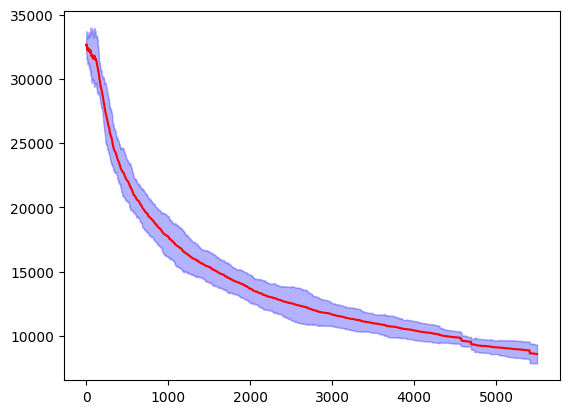

In [14]:
# standard case
initial = SimulatedAnnealing('a280.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.type_of_temperature_change = "log"
initial.iterations = 10
initial.max_iter = 5500

# run with current settings
initial.initialize()
# initial.iteration_distance()
initial.iteration_confidence()

# alpha1
alpha1 = SimulatedAnnealing('a280.tsp')
alpha1.same_solution_max = 100
alpha1.same_cost_diff_max = 500
alpha1.alpha = 0.95
alpha1.type_of_temperature_change = "log"
alpha1.iterations = 10
alpha1.max_iter = 5500

# run with current settings
alpha1.initialize()
# alpha1.iteration_distance()
alpha1.iteration_confidence()


# alpha 2
alpha2 = SimulatedAnnealing('a280.tsp')
alpha2.same_solution_max = 100
alpha2.same_cost_diff_max = 500
alpha2.alpha = 0.9
alpha2.type_of_temperature_change = "log"
alpha2.iterations = 10
alpha2.max_iter = 5500

# run with current settings
alpha2.initialize()
# alpha2.iteration_distance()
alpha2.iteration_confidence()

## Extra 2: vary perturbation methods

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


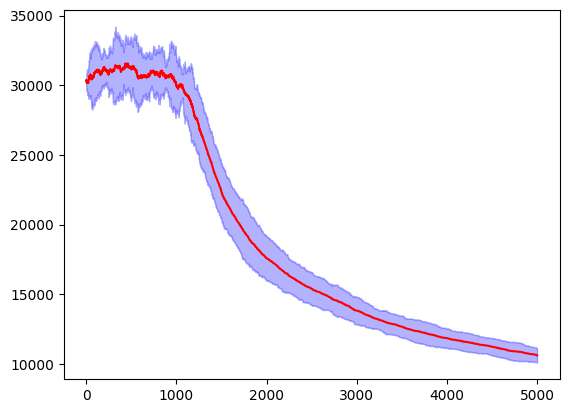

In [13]:
# standard case
initial = SimulatedAnnealing('a280.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.type_of_temperature_change = "log"
initial.perturbations_options = [0, 1, 2, 3] # choose which method to include: 0 - invert, 1 - inverse, 2 - swap, 3 - swap route
initial.iterations = 10

# run with current settings
initial.initialize()
# initial.iteration_distance()
initial.iteration_confidence()